# Neural Networks

Aliya Ghassaei

This homework will be an extension of the lab we did working with CIFAR data (the homework doesn't come bundled with the data since you already have it from lab. If you don't have it you can get it from the lab from this week). We'll convert our network from a binary to a multiclass setting, much like you did with the MNIST data, and we'll experiment with some ways to improve network performance.

NOTE: We'll be talking about PyTorch during the week before this homework is due, but _don't_ use PyTorch for this homework. We'll switch over the PyTorch for the next one, but I think it's important to understand how the machine learning algorithms work under the hood.

## Guidelines
The baseline assignment is to define a neural network with at least one hidden layer using ReLU as the activation function. Train your network using the multiclass cross-entropy loss we defined in the previous homework assignment. Completing this part of the assignment (correctly) guarantees at least a C.

Beyond this, I have two lists of possible extensions:

- Minor
  + Add $L_2$ regularization. That is, if your parameters are $\beta$, minimize $L(\beta) + \lambda \| \beta \|_2^2$. Remember that $\| \beta \|_2^2 = \sum_i \beta_i^2$. You'll need to compute the gradient of $\| \beta \|_2^2$ and add it to your gradients for each parameter. You'll need to choose a regularization hyperparameter $\lambda$. I recommend starting around 1e-4. How does this change your results (if at all)? (Note that the regularization in the lab solution is $L_1$ regularization, so this is slightly different.)
  + Use a different activation function to replace the ReLU. This will require computing the derivative of your new activation function and replacing the derivative of ReLU with it. (The derivative of ReLU is the line in the lab `h_grad[h <= 0] = 0`. We've already computed the derivative of $\tanh$ in a previous homework, so that might be a good choice.) How does this change your results (if at all)?
  + Split your data into a training set and a validation set. Track and plot the training accuracy and validation accuracy during training. What (if any) information can you get from this plot?
- Major
  + Define your training function to accept a _list_ of hidden layer sizes and set up the network accordingly. For example, I should be able to pass your function the list `[256, 128]` and it will create a network with two hidden layers of sizes 256 and 128. But if I pass it `[256, 128, 64]` then it should create a network with _three_ hidden layers of appropriate size.
  + Use at least two hidden layers and add data augmentation. That is, for each iteration of training, you should randomly perturb each image independently. A couple of good options are listed below. Implement at least two.
    * Horizontal flip: randomly mirror an image with probability 0.5
    * Grayscale: replace each color value with the average of all three color values in an image with probability 0.5
    * Brightness: choose a factor uniformly at random in some range around one (say 0.9-1.1) then multiply each pixel value by that factor. You can also choose different factors for each color channel.
    * Shift: randomly choose a number of pixels (our images are small so probably around 3 or 4 at most) and a direction. Shift the image by the chosen number of pixels in the chosen direction and fill in the leftover gap with the mean values of each color.
    
Using at least two hidden layers and doing any two of the minor extensions _or_ a major extension (correctly) guarantees a B. Doing all of the minor extensions and at least one of the major extensions (correctly) is good for an A.

In [1]:
import pickle
import numpy as np

# Define a function to load the CIFAR dataset
def load_data(dirname):
    data = []
    labels = []
    for i in range(1, 6):
        with open(dirname + '/data_batch_' + str(i), 'rb') as fo:
            obj = pickle.load(fo, encoding='bytes')
            data.append(obj[b'data'])
            labels.append(obj[b'labels'])
    with open(dirname + '/batches.meta', 'rb') as fo:
        names = pickle.load(fo, encoding='bytes')[b'label_names']
    data = np.concatenate(data, axis=0)
    labels = np.concatenate(labels)
    return data.reshape(-1, 3, 32, 32), labels, names


In [2]:
# Load the CIFAR dataset
images, labels, names = load_data('../labs/networks_lab/data/cifar')
permute = np.random.permutation(labels.shape[0])
images = images[permute]
labels = labels[permute]

# Compute the mean and standard deviation
mean = np.mean(images, axis=(0, 2, 3), keepdims=True)
std = np.std(images, axis=(0, 2, 3), keepdims=True)

# Normalize the images
norm_images = (images - mean) / std

In [3]:
# Divide the data into training and validation sets
train_size = int(0.8 * images.shape[0])
train_images = norm_images[:train_size]
train_labels = labels[:train_size]
valid_images = norm_images[train_size:]
valid_labels = labels[train_size:]

In [4]:
# Reshape the images
train_images = images[:train_size].reshape(-1, 3 * 32 * 32)
train_labels = labels[:train_size]
valid_images = images[train_size:].reshape(-1, 3 * 32 * 32)
valid_labels = labels[train_size:]

In [30]:
# Note: this doesn't work because of some shape error, but I ran out of time

# Define a function to apply the appropriate activation function. assuming already iterated over
def activate(fun, x, w, b):
    if fun == "ReLU":
        return np.maximum(x @ w + b, 0)
    if fun == "tanh":
        return np.tanh(x @ w + b)
    
# Define a function to apply the appropriate derivative
def derivative(fun, grads, h, i):
    if fun == "ReLU":
        grads[0][h[i] <= 0] = 0

    if fun == "tanh":
        grads[0] *= (1-np.tanh(h[i])**2)
    
    return grads

In [43]:
# Define a training function 
def train(train_data, train_outputs, valid_data, valid_outputs, 
          epochs=10, batch_size=128, l2=False, activation="ReLU", 
          hidden_layers=[256, 128], reg=1e-4, lr=1e-5):
    
    # Random number generator
    rng = np.random.default_rng() 

    # Get number of hidden layers (default is 2)
    hl = len(hidden_layers)

    # Initialize weights list with the weight of the first layer
    w = [rng.normal(scale=np.sqrt(2 / (train_data.shape[1] + hidden_layers[0])), size=(train_data.shape[1], hidden_layers[0]))]

    # Set up weights for each hidden layer, excluding the last one. For some reason this works even though I don't account for the 0 index?
    for i, size in enumerate(hidden_layers[:-1]):
        next_size = hidden_layers[i + 1]
        w.append(rng.normal(scale=np.sqrt(2/(size + next_size)), size=(size, next_size)))

    # Append the weights for the last layer. 10 here refers to the number of classes
    w.append(np.zeros((hidden_layers[-1], 10)))

    # Initialize the bias list 
    b = [np.zeros(size) for size in hidden_layers]
    b.append(np.zeros(10))
    b.append(np.array([0.]))
    
    # Set up batches
    num_batches = train_data.shape[0] // batch_size
    if train_data.shape[0] % batch_size != 0:
        num_batches += 1

    # After each epoch, save the training and validation accuracies to graph
    train_accs = []
    valid_accs = []

    for i in range(epochs):
        # Shuffle the data at the start of each epoch
        permute = rng.permutation(train_data.shape[0])
        train_data = train_data[permute]
        train_outputs = train_outputs[permute]

        # For each batch
        for j in range(num_batches):

            # Separate out a batch
            end_index = min(batch_size * (j + 1), train_data.shape[0])
            batch_data = train_data[batch_size * j : end_index]
            batch_outputs = train_outputs[batch_size * j : end_index]

            # Get the one-hot encoding for this batch
            one_hot = np.zeros((batch_outputs.shape[0], 10))
            one_hot[np.arange(batch_outputs.shape[0]), batch_outputs] = 1

            # Initialize list for forward pass calculations
            # h.append(activate(activation, batch_data, w[0], b[0]))
            h = [np.maximum(batch_data @ w[0] + b[0], 0)]
            


            # Iterate over the weights and biases, appending the next calculation to h
            for idx, (weight, bias) in enumerate(zip(w[:-1], b)):
                if idx == 0: continue
                h.append(np.maximum(h[idx - 1] @ weight + bias, 0))
                # h.append(activate(activation, h, weight, bias))

            # Calculate loss and gradient for last layer
            logits = (h[-1] @ w[-1] + b[-1]).squeeze() 
            preds = np.exp(logits) / np.sum(np.exp(logits), axis=1)[:, np.newaxis]
            correct_pred = preds[np.arange(preds.shape[0]), batch_outputs]
            loss = np.mean(-np.log(correct_pred))
            logit_grad = preds - one_hot

            # Initialize lists for the different gradients for the last layer
            b_grads = [np.sum(logit_grad, axis=0)]
            w_grads = [h[-1].T @ logit_grad]


            # last_h_grad = logit_grad @ w[-1].T
            # h_grads = [derivative(activation, last_h_grad, h, 0)]
            h_grads = [logit_grad @ w[-1].T]
            h_grads[0][h[-1] <= 0] = 0
            
            # Back propogate and compute the gradients of the internal layers
            for k in range(len(h)-1, 0, -1):
                b_grads.insert(0,np.sum(h_grads[0], axis=0))  
                w_grads.insert(0,h[k-1].T @ h_grads[0])      
                newh = h_grads[0] @ w[k].T
                # newh = derivative(activation, newh, h, k-1 )
                newh[h[k-1] <= 0] = 0
                h_grads.insert(0,newh)

            # Compute the first gradients
            b_grads.insert(0, np.sum(h_grads[0], axis=0))
            w_grads.insert(0, batch_data.T @ h_grads[0])

            # Do L2 regularization
            if l2:
                w_grads = [grad + reg * 2*weight for grad, weight in zip(w_grads, w)]
                b_grads = [grad + reg * 2*bias for grad, bias in zip(b_grads, b)]

            # Update parameters
            for k in range(len(w)):
                w[k] = w[k] - lr * w_grads[k]
                b[k] = b[k] - lr * b_grads[k]

        # Validate results
        valid_h = [np.maximum(valid_data @ w[0] + b[0], 0)]
        # valid_h = [activate(activation, valid_data, w[0], b[0])]
        for k in (1,hl-1):
            valid_h.append(np.maximum(valid_h[k-1] @ w[k] + b[k], 0))
            # valid_h.append(activate(activation, valid_h[k-1], w[k], b[k] ))
        
        # Get validation accuracy
        valid_logits = (valid_h[-1] @ w[-1] + b[-1])
        # print("valid_logits.shape = ", valid_logits.shape)
        valid_preds = np.exp(valid_logits) / np.sum(np.exp(valid_logits), axis=1)[:, np.newaxis]
        # print("valid_preds.shape = ", valid_preds.shape)
        valid_max = np.argmax(valid_preds, axis=1)
        # print("valid_max.shape = ", valid_max.shape)
        valid_accuracy = np.mean(valid_max == valid_outputs)
        # print("valid_accuracy.shape = ", valid_accuracy.shape)
        valid_accs.append(valid_accuracy)
        # print("valid_accs: ", valid_accs)

        # print("logits.shape = ", logits.shape)

        # Get training accuracy
        h = [np.maximum(train_data @ w[0] + b[0], 0)]
        # h = [activate(activation, train_data, w[0], b[0])]
        for k in (1,hl-1):
            h.append(np.maximum(h[k-1] @ w[k] + b[k], 0))
            # h.append(activate(activation, h[k-1], w[k], b[k] ))

        train_logits = (h[-1] @ w[-1] + b[-1])
        # print("train_logits.shape = ", train_logits.shape)
        train_preds = np.exp(train_logits) / np.sum(np.exp(train_logits), axis=1)[:, np.newaxis]
        # print("train_preds.shape = ", train_preds.shape)
        train_max = np.argmax(train_preds, axis=1)
        # print("train_max.shape = ", train_max.shape)
        train_accuracy = np.mean(train_max == train_outputs)
        train_accs.append(train_accuracy)

        print("Epoch:", i, "Loss:", loss, "Validation accuracy:", valid_accuracy)
    
    # Return weights and biases
    return w, b, valid_accs, train_accs





In [47]:
# Define a function to generate predictions based on the weights and biases of the model
def forward(xs, w, b, hl, activation=None):
    # Validate results
    h = [np.maximum(xs @ w[0] + b[0], 0)]
    # h = [activate(activation, train_images, w[0], b[0], 0)]
    for k in (1,hl-1):
        h.append(np.maximum(h[k-1] @ w[k] + b[k], 0))


    logits = (h[-1] @ w[-1] + b[-1])
    p = np.exp(logits) / np.sum(np.exp(logits), axis=1)[:, np.newaxis]
    
    return p
    

In [56]:
# Train a model and get the weights, biases, and accuracies 
weights, biases, valid_accs, train_accs = train(train_images, 
                        train_labels, 
                        valid_images, 
                        valid_labels, 
                        l2=True, 
                        hidden_layers=[256, 128, 64],
                        reg=1e-1,
                        lr=1e-5,
                        epochs=30
                        )


Epoch: 0 Loss: 1.9728502694396792 Validation accuracy: 0.2688
Epoch: 1 Loss: 1.934456229246634 Validation accuracy: 0.3117
Epoch: 2 Loss: 1.9190361579204767 Validation accuracy: 0.3306
Epoch: 3 Loss: 1.7329516449592022 Validation accuracy: 0.3357
Epoch: 4 Loss: 1.8435281049084518 Validation accuracy: 0.3527
Epoch: 5 Loss: 1.728743980981144 Validation accuracy: 0.3568
Epoch: 6 Loss: 1.5536788122718639 Validation accuracy: 0.3672
Epoch: 7 Loss: 1.6117157111236837 Validation accuracy: 0.3625
Epoch: 8 Loss: 1.7199361829803075 Validation accuracy: 0.3818
Epoch: 9 Loss: 1.6011578118851562 Validation accuracy: 0.392
Epoch: 10 Loss: 1.588741461199646 Validation accuracy: 0.3855
Epoch: 11 Loss: 1.7857553813898144 Validation accuracy: 0.4013
Epoch: 12 Loss: 1.733382323419741 Validation accuracy: 0.3996
Epoch: 13 Loss: 1.7607686593490275 Validation accuracy: 0.4073
Epoch: 14 Loss: 1.6465825429091947 Validation accuracy: 0.4047
Epoch: 15 Loss: 1.6871798447025776 Validation accuracy: 0.407
Epoch: 1

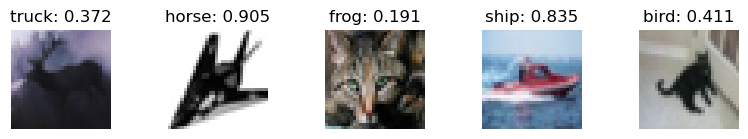

In [61]:
# Make predictions based on that model

import matplotlib.pyplot as plt

idx = np.random.randint(valid_images.shape[0], size=(5,))
preds = forward(valid_images[idx], weights, biases, 3)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

fig, axs = plt.subplots(1, 5, figsize=(8, 8))
fig.tight_layout()
for i in range(5):
    axs[i].imshow(images[train_size + idx[i]].transpose((1, 2, 0)))
    axs[i].title.set_text(classes[np.argmax(preds[i])]  + ": {:.3f}".format(np.max(preds[i])))
    axs[i].axis('off')
plt.show()

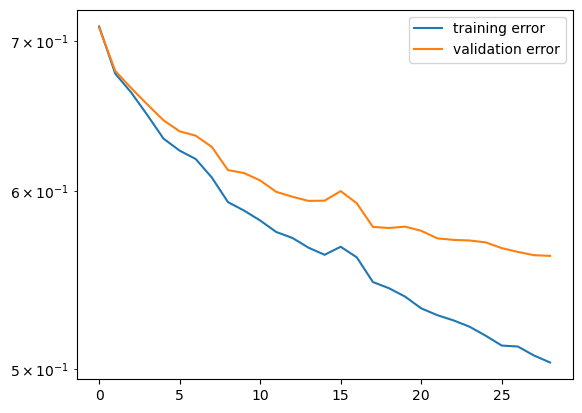

In [58]:
# Plot the training error against the validation error

smooth_train = np.convolve(train_accs, np.ones(2) / 2, mode='valid')
smooth_valid = np.convolve(valid_accs, np.ones(2) / 2, mode='valid')
plt.plot(range(len(smooth_train)), 1-smooth_train, label='training error')
plt.plot(range(len(smooth_valid)), 1-smooth_valid, label='validation error')
plt.yscale('log')
plt.legend()
plt.show()

### Observations:

Although I couldn't get the activation function to work generally, I noticed that ReLU seemed to yield higher accuracy than tanh. Adjusting the regularization parameter didn't change the accuracy that much. The main difference I saw was between not having $L_2$ and having it (it was more accurate with $L_2$). Once the training and validation errors diverge, they seem to decrease at similar rates. I think that this is good, but it might mean that we're overfitting to the training data because the validation error has a similar trend to the training error but is consistently worse. 